# CRND Ablation & Robustness Analysis

**Systematic ablation of the Cross-Representation Neighborhood Dissonance (CRND) framework across 6 dimensions:**

1. **Phase 1** — Feature space construction (TF-IDF, SentenceTransformer fallback via SVD, simulated LLM zero-shot)
2. **Phase 2** — k-sensitivity analysis (k ∈ {5, 10, 15, 20, 30, 50})
3. **Phase 3** — PCA dimensionality for Schoener's D stability (d ∈ {2, 3, 5, 10, 20})
4. **Phase 4** — Distance metric ablation (euclidean, cosine, manhattan)
5. **Phase 5** — Alternative CRND formulations (Jaccard, RBO, weighted Jaccard, pairwise decomposition)
6. **Phase 6** — Confound disentanglement via partial Spearman correlations

Includes single-space kNN anomaly baselines for comparison. Runs on clinical text classification data.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# pingouin — NOT on Colab, always install
_pip('pingouin==0.5.5')

# Core packages (pre-installed on Colab, install locally to match Colab env)
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1',
         'scipy==1.16.3', 'matplotlib==3.10.0', 'tabulate==0.9.0')

# Note: sentence-transformers is optional; code uses TF-IDF SVD fallback
# if unavailable. Uncomment below to install (adds ~3 min):
# _pip('sentence-transformers==3.4.1')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import os
import sys
import time
from itertools import combinations
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine as cosine_dist
from scipy.stats import gaussian_kde, pearsonr, spearmanr
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## Data Loading

Load the mini demo dataset (clinical text classification examples). Tries GitHub URL first, falls back to local file.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/experiment_iter3_crnd_ablation_r/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data['datasets']:
    labels = [ex['output'] for ex in ds['examples']]
    label_counts = {}
    for lbl in labels:
        label_counts[lbl] = label_counts.get(lbl, 0) + 1
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples, classes={label_counts}")

Loaded 1 dataset(s)
  medical_abstracts: 50 examples, classes={'Cardiovascular_diseases': 10, 'Digestive_system_diseases': 10, 'General_pathological_conditions': 10, 'Neoplasms': 10, 'Nervous_system_diseases': 10}


## Configuration

All tunable parameters. Adjust these to control runtime and analysis depth.

In [5]:
# ── Tunable parameters ──────────────────────────────────────────────
# Original values (for full production run on 1000+ examples):
# MAX_EXAMPLES_PER_DATASET = 1000

# Demo values (full analysis depth on 50 examples for ~5 min budget):
K_VALUES = [5, 10, 15, 20, 30, 50]
PCA_DIMS = [2, 3, 5, 10, 20]
METRICS = ["euclidean", "cosine", "manhattan"]
NOISE_RATE = 0.10
N_SEEDS = 5
DEFAULT_K = 10
MAX_EXAMPLES_PER_DATASET = 50
GRID_SIZE = 40
N_RANDOM_PROJECTIONS = 3

GLOBAL_START = time.time()

## Utility Functions

Core CRND computation functions: softmax, Jaccard/weighted Jaccard/RBO similarity, kNN construction, noise detection AUC evaluation.

In [6]:
def softmax(x: np.ndarray, temperature: float = 3.0) -> np.ndarray:
    """Compute softmax with temperature scaling."""
    x_scaled = x * temperature
    e_x = np.exp(x_scaled - np.max(x_scaled))
    return e_x / e_x.sum()


def flatten_upper_triangle(matrix: list[list[float]]) -> np.ndarray:
    """Extract upper-triangle values from a symmetric matrix (as list of lists)."""
    arr = np.array(matrix)
    n = arr.shape[0]
    indices = np.triu_indices(n, k=1)
    return arr[indices]


def compute_crnd_jaccard(
    neighbor_sets: dict[str, np.ndarray],
    n_samples: int,
) -> np.ndarray:
    """Compute CRND using Jaccard similarity across feature spaces."""
    space_names = list(neighbor_sets.keys())
    crnd = np.zeros(n_samples)
    pairs = list(combinations(space_names, 2))
    if len(pairs) == 0:
        return crnd
    for i in range(n_samples):
        jaccards = []
        for s1, s2 in pairs:
            set1 = set(neighbor_sets[s1][i].tolist())
            set2 = set(neighbor_sets[s2][i].tolist())
            union_size = len(set1 | set2)
            if union_size == 0:
                jaccards.append(0.0)
            else:
                jaccards.append(len(set1 & set2) / union_size)
        crnd[i] = 1.0 - np.mean(jaccards)
    return crnd


def compute_crnd_weighted_jaccard(
    neighbor_sets: dict[str, np.ndarray],
    n_samples: int,
) -> np.ndarray:
    """Compute CRND using weighted Jaccard (weight by 1/rank)."""
    space_names = list(neighbor_sets.keys())
    crnd = np.zeros(n_samples)
    pairs = list(combinations(space_names, 2))
    if len(pairs) == 0:
        return crnd
    for i in range(n_samples):
        wj_scores = []
        for s1, s2 in pairs:
            neighbors_1 = neighbor_sets[s1][i].tolist()
            neighbors_2 = neighbor_sets[s2][i].tolist()
            w1 = {n: 1.0 / (rank + 1) for rank, n in enumerate(neighbors_1)}
            w2 = {n: 1.0 / (rank + 1) for rank, n in enumerate(neighbors_2)}
            all_neighbors = set(neighbors_1) | set(neighbors_2)
            intersection = set(neighbors_1) & set(neighbors_2)
            w_inter = sum(max(w1.get(j, 0), w2.get(j, 0)) for j in intersection)
            w_union = sum(max(w1.get(j, 0), w2.get(j, 0)) for j in all_neighbors)
            wj = w_inter / w_union if w_union > 0 else 0.0
            wj_scores.append(wj)
        crnd[i] = 1.0 - np.mean(wj_scores)
    return crnd


def rbo_score(list1: list, list2: list, p: float = 0.9) -> float:
    """Rank-Biased Overlap (Webber et al. 2010)."""
    k = max(len(list1), len(list2))
    if k == 0:
        return 0.0
    score = 0.0
    for d in range(1, k + 1):
        set1_d = set(list1[:d])
        set2_d = set(list2[:d])
        overlap_d = len(set1_d & set2_d) / d
        score += (p ** (d - 1)) * overlap_d
    return (1.0 - p) * score


def compute_crnd_rbo(
    neighbor_sets: dict[str, np.ndarray],
    n_samples: int,
    p: float = 0.9,
) -> np.ndarray:
    """Compute CRND using Rank-Biased Overlap."""
    space_names = list(neighbor_sets.keys())
    crnd = np.zeros(n_samples)
    pairs = list(combinations(space_names, 2))
    if len(pairs) == 0:
        return crnd
    for i in range(n_samples):
        rbo_scores = []
        for s1, s2 in pairs:
            l1 = neighbor_sets[s1][i].tolist()
            l2 = neighbor_sets[s2][i].tolist()
            rbo_scores.append(rbo_score(l1, l2, p=p))
        crnd[i] = 1.0 - np.mean(rbo_scores)
    return crnd


def compute_pairwise_crnd(
    neighbor_sets: dict[str, np.ndarray],
    n_samples: int,
) -> dict[str, np.ndarray]:
    """Compute CRND per pair of feature spaces (Jaccard)."""
    space_names = list(neighbor_sets.keys())
    pairs = list(combinations(space_names, 2))
    result = {}
    for s1, s2 in pairs:
        key = f"{s1}_vs_{s2}"
        crnd = np.zeros(n_samples)
        for i in range(n_samples):
            set1 = set(neighbor_sets[s1][i].tolist())
            set2 = set(neighbor_sets[s2][i].tolist())
            union_size = len(set1 | set2)
            if union_size == 0:
                crnd[i] = 0.0
            else:
                crnd[i] = 1.0 - len(set1 & set2) / union_size
        result[key] = crnd
    return result


def noise_detection_auc(
    crnd: np.ndarray,
    n_samples: int,
    noise_rate: float = NOISE_RATE,
    n_seeds: int = N_SEEDS,
) -> tuple[float, float]:
    """Evaluate noise detection ROC-AUC over multiple random seeds."""
    auc_scores = []
    for seed in range(n_seeds):
        rng = np.random.default_rng(seed + 42)
        n_flip = int(noise_rate * n_samples)
        if n_flip == 0:
            n_flip = 1
        flip_indices = rng.choice(n_samples, size=n_flip, replace=False)
        noise_indicator = np.zeros(n_samples)
        noise_indicator[flip_indices] = 1.0
        if noise_indicator.sum() == 0 or noise_indicator.sum() == n_samples:
            continue
        try:
            auc = roc_auc_score(noise_indicator, crnd)
            auc_scores.append(auc)
        except ValueError:
            continue
    if len(auc_scores) == 0:
        return 0.5, 0.0
    return float(np.mean(auc_scores)), float(np.std(auc_scores))


def build_knn(
    features: np.ndarray,
    k: int,
    metric: str = "euclidean",
) -> np.ndarray:
    """Build k-NN and return neighbor indices (excluding self)."""
    n = features.shape[0]
    actual_k = min(k + 1, n)
    nn = NearestNeighbors(n_neighbors=actual_k, metric=metric, algorithm="auto")
    nn.fit(features)
    distances, indices = nn.kneighbors(features)
    if actual_k > 1:
        return indices[:, 1:]
    else:
        return indices


def build_knn_with_distances(
    features: np.ndarray,
    k: int,
    metric: str = "euclidean",
) -> tuple[np.ndarray, np.ndarray]:
    """Build k-NN and return (distances, indices) excluding self."""
    n = features.shape[0]
    actual_k = min(k + 1, n)
    nn = NearestNeighbors(n_neighbors=actual_k, metric=metric, algorithm="auto")
    nn.fit(features)
    distances, indices = nn.kneighbors(features)
    if actual_k > 1:
        return distances[:, 1:], indices[:, 1:]
    else:
        return distances, indices

print("Utility functions defined.")

Utility functions defined.


## Phase 0: Parse Datasets

Extract texts, labels, and class names from each loaded dataset.

In [7]:
datasets = {}
for ds in data["datasets"]:
    name = ds["dataset"]
    examples = ds["examples"][:MAX_EXAMPLES_PER_DATASET]
    texts = [ex["input"] for ex in examples]
    labels = [ex["output"] for ex in examples]
    class_names = sorted(set(labels))
    datasets[name] = {
        "texts": texts,
        "labels": labels,
        "n_classes": len(class_names),
        "class_names": class_names,
        "raw_examples": examples,
    }
    label_counts = {}
    for lbl in labels:
        label_counts[lbl] = label_counts.get(lbl, 0) + 1
    print(f"{name}: {len(texts)} examples, {len(class_names)} classes, dist={json.dumps(label_counts, sort_keys=True)[:200]}")

medical_abstracts: 50 examples, 5 classes, dist={"Cardiovascular_diseases": 10, "Digestive_system_diseases": 10, "General_pathological_conditions": 10, "Neoplasms": 10, "Nervous_system_diseases": 10}


## Phase 1: Feature Space Construction

Build three feature spaces per dataset:
- **TF-IDF**: Sparse bag-of-words features with sublinear TF and bigrams
- **Sentence Transformer**: Dense embeddings (falls back to TF-IDF SVD if model unavailable)
- **Simulated LLM zero-shot**: Class-probability vectors via cosine similarity to TF-IDF class centroids + softmax

In [8]:
def build_feature_spaces(texts, labels, class_names, dataset_name):
    """Build TF-IDF, sentence transformer, and simulated LLM feature spaces."""
    t0 = time.time()
    n = len(texts)
    feature_spaces = {}

    # 1a. TF-IDF
    print(f"  [{dataset_name}] Building TF-IDF features...")
    max_features = min(5000, n * 10)
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words="english",
        ngram_range=(1, 2),
        min_df=1 if n < 20 else 2,
        max_df=0.95,
        sublinear_tf=True,
    )
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_spaces["tfidf"] = tfidf_matrix.toarray().astype(np.float32)
    feature_spaces["_tfidf_vectorizer"] = vectorizer
    print(f"    TF-IDF shape: {feature_spaces['tfidf'].shape}")

    # 1b. Sentence transformer embeddings (with SVD fallback)
    print(f"  [{dataset_name}] Building sentence transformer embeddings...")
    try:
        from sentence_transformers import SentenceTransformer
        if not hasattr(build_feature_spaces, "_st_model"):
            build_feature_spaces._st_model = SentenceTransformer("all-MiniLM-L6-v2")
        model = build_feature_spaces._st_model
        truncated = [t[:512] for t in texts]
        embeddings = model.encode(
            truncated,
            batch_size=256,
            normalize_embeddings=True,
            show_progress_bar=False,
        )
        feature_spaces["sentence_transformer"] = embeddings.astype(np.float32)
        print(f"    SentenceTransformer shape: {embeddings.shape}")
    except Exception as e:
        print(f"  [{dataset_name}] SentenceTransformer failed ({e}), using TF-IDF SVD fallback")
        svd = TruncatedSVD(n_components=min(384, tfidf_matrix.shape[1] - 1, n - 1))
        fallback = svd.fit_transform(tfidf_matrix).astype(np.float32)
        norms = np.linalg.norm(fallback, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        fallback = fallback / norms
        feature_spaces["sentence_transformer"] = fallback
        print(f"    SVD fallback shape: {fallback.shape}")

    # 1c. Simulated LLM zero-shot features
    print(f"  [{dataset_name}] Building simulated LLM features...")
    n_classes = len(class_names)
    tfidf_dense = feature_spaces["tfidf"]
    class_centroids = np.zeros((n_classes, tfidf_dense.shape[1]), dtype=np.float32)
    for ci, cn in enumerate(class_names):
        mask = np.array([l == cn for l in labels])
        if mask.sum() > 0:
            class_centroids[ci] = tfidf_dense[mask].mean(axis=0)

    llm_features = np.zeros((n, n_classes), dtype=np.float32)
    for i in range(n):
        vec = tfidf_dense[i]
        vec_norm = np.linalg.norm(vec)
        if vec_norm == 0:
            llm_features[i] = np.ones(n_classes) / n_classes
            continue
        sims = np.zeros(n_classes)
        for ci in range(n_classes):
            c_norm = np.linalg.norm(class_centroids[ci])
            if c_norm == 0:
                sims[ci] = 0.0
            else:
                sims[ci] = np.dot(vec, class_centroids[ci]) / (vec_norm * c_norm)
        llm_features[i] = softmax(sims, temperature=3.0)

    feature_spaces["llm_zeroshot"] = llm_features
    print(f"    LLM features shape: {llm_features.shape}")

    elapsed = time.time() - t0
    print(f"  [{dataset_name}] Feature construction done in {elapsed:.1f}s")
    return feature_spaces


# Build feature spaces for all datasets
all_feature_spaces = {}
for ds_name, ds_data in datasets.items():
    all_feature_spaces[ds_name] = build_feature_spaces(
        texts=ds_data["texts"],
        labels=ds_data["labels"],
        class_names=ds_data["class_names"],
        dataset_name=ds_name,
    )

  [medical_abstracts] Building TF-IDF features...
    TF-IDF shape: (50, 500)
  [medical_abstracts] Building sentence transformer embeddings...
  [medical_abstracts] SentenceTransformer failed (No module named 'sentence_transformers'), using TF-IDF SVD fallback


    SVD fallback shape: (50, 49)
  [medical_abstracts] Building simulated LLM features...
    LLM features shape: (50, 5)
  [medical_abstracts] Feature construction done in 1.7s


## Phase 2: k-Sensitivity Analysis

Evaluate CRND noise detection AUC across different neighborhood sizes k. This reveals how sensitive the CRND metric is to the choice of k in kNN.

In [9]:
def phase2_k_sensitivity(feature_spaces, n_samples, dataset_name):
    """Evaluate CRND noise detection across different k values."""
    t0 = time.time()
    print(f"  [{dataset_name}] Phase 2: k sensitivity analysis")
    results = {}
    analysis_spaces = {k: v for k, v in feature_spaces.items() if not k.startswith("_")}

    for k in K_VALUES:
        if k >= n_samples:
            print(f"    k={k} >= N={n_samples}, skipping")
            continue
        neighbor_sets = {}
        for space_name, features in analysis_spaces.items():
            indices = build_knn(features, k=k, metric="euclidean")
            neighbor_sets[space_name] = indices
        crnd = compute_crnd_jaccard(neighbor_sets, n_samples)
        mean_auc, std_auc = noise_detection_auc(crnd, n_samples)
        results[str(k)] = {
            "mean_auc": round(mean_auc, 6),
            "std_auc": round(std_auc, 6),
            "mean_crnd": round(float(np.mean(crnd)), 6),
            "std_crnd": round(float(np.std(crnd)), 6),
        }
        print(f"    k={k}: AUC={mean_auc:.4f}±{std_auc:.4f}, CRND={np.mean(crnd):.4f}±{np.std(crnd):.4f}")

    elapsed = time.time() - t0
    print(f"  [{dataset_name}] Phase 2 done in {elapsed:.1f}s")
    return results


metadata_k_sensitivity = {}
for ds_name, ds_data in datasets.items():
    metadata_k_sensitivity[ds_name] = phase2_k_sensitivity(
        feature_spaces=all_feature_spaces[ds_name],
        n_samples=len(ds_data["texts"]),
        dataset_name=ds_name,
    )

  [medical_abstracts] Phase 2: k sensitivity analysis
    k=5: AUC=0.5396±0.0797, CRND=0.6086±0.0827
    k=10: AUC=0.5351±0.1196, CRND=0.5619±0.0668


    k=15: AUC=0.6418±0.1030, CRND=0.4978±0.0697
    k=20: AUC=0.5920±0.0909, CRND=0.4330±0.0695
    k=30: AUC=0.5996±0.1209, CRND=0.3382±0.0670
    k=50 >= N=50, skipping
  [medical_abstracts] Phase 2 done in 0.3s


## Phase 3: PCA Dimensionality for Schoener's D

Compute Schoener's D overlap metric between class distributions at various PCA dimensionalities. Tests stability of the overlap measure across different projection dimensions.

In [10]:
def compute_schoeners_d_2d(points_i, points_j, all_projected, grid_size=GRID_SIZE):
    """Compute Schoener's D between two groups using 2D KDE."""
    try:
        kde_i = gaussian_kde(points_i.T)
        kde_j = gaussian_kde(points_j.T)
    except (np.linalg.LinAlgError, ValueError):
        return float("nan")
    d = points_i.shape[1]
    grid_ranges = [
        np.linspace(all_projected[:, dim].min(), all_projected[:, dim].max(), grid_size)
        for dim in range(d)
    ]
    mesh = np.meshgrid(*grid_ranges)
    grid_points = np.vstack([m.ravel() for m in mesh])
    try:
        pdf_i = kde_i(grid_points)
        pdf_j = kde_j(grid_points)
    except (np.linalg.LinAlgError, ValueError):
        return float("nan")
    total_i = pdf_i.sum()
    total_j = pdf_j.sum()
    if total_i == 0 or total_j == 0:
        return float("nan")
    pdf_i /= total_i
    pdf_j /= total_j
    D = 1.0 - 0.5 * np.sum(np.abs(pdf_i - pdf_j))
    return float(np.clip(D, 0.0, 1.0))


def phase3_pca_dimensionality(feature_spaces, labels, class_names, dataset_name):
    """Compute Schoener's D at various PCA dimensionalities."""
    t0 = time.time()
    print(f"  [{dataset_name}] Phase 3: PCA dimensionality for Schoener's D")
    analysis_spaces = {k: v for k, v in feature_spaces.items() if not k.startswith("_")}
    schoeners_results = {}
    pca_stability = {}
    labels_arr = np.array(labels)
    n_classes = len(class_names)

    for space_name, features in analysis_spaces.items():
        print(f"    Space: {space_name}")
        schoeners_results[space_name] = {}
        max_dim = min(max(PCA_DIMS), features.shape[1], features.shape[0] - 1)
        if max_dim < 2:
            print(f"      max_dim={max_dim}, skipping PCA")
            continue
        try:
            if hasattr(features, 'toarray'):
                reducer = TruncatedSVD(n_components=max_dim)
            else:
                reducer = PCA(n_components=max_dim)
            projected_full = reducer.fit_transform(features)
            evr = getattr(reducer, 'explained_variance_ratio_', np.zeros(max_dim))
        except Exception as e:
            print(f"      PCA/SVD failed for {space_name}: {e}")
            continue

        for d in PCA_DIMS:
            if d > max_dim:
                continue
            projected = projected_full[:, :d]
            explained_var = float(evr[:d].sum()) if len(evr) >= d else 0.0
            D_matrix = np.ones((n_classes, n_classes))
            for (ci, class_i), (cj, class_j) in combinations(enumerate(class_names), 2):
                mask_i = labels_arr == class_i
                mask_j = labels_arr == class_j
                pts_i = projected[mask_i]
                pts_j = projected[mask_j]
                if len(pts_i) < 3 or len(pts_j) < 3:
                    D_matrix[ci, cj] = D_matrix[cj, ci] = float("nan")
                    continue
                if d <= 3:
                    all_pts = np.vstack([pts_i, pts_j])
                    D_val = compute_schoeners_d_2d(pts_i, pts_j, all_pts, grid_size=GRID_SIZE)
                else:
                    D_projections = []
                    for proj_seed in range(N_RANDOM_PROJECTIONS):
                        rng_proj = np.random.default_rng(proj_seed)
                        proj_matrix = rng_proj.standard_normal((d, 2))
                        proj_matrix /= np.linalg.norm(proj_matrix, axis=0, keepdims=True)
                        proj_i = pts_i @ proj_matrix
                        proj_j = pts_j @ proj_matrix
                        all_proj = np.vstack([proj_i, proj_j])
                        D_val_2d = compute_schoeners_d_2d(proj_i, proj_j, all_proj, grid_size=GRID_SIZE)
                        if not np.isnan(D_val_2d):
                            D_projections.append(D_val_2d)
                    D_val = float(np.mean(D_projections)) if D_projections else float("nan")
                D_matrix[ci, cj] = D_matrix[cj, ci] = D_val

            schoeners_results[space_name][str(d)] = {
                "D_matrix": [[round(v, 4) if not np.isnan(v) else None for v in row] for row in D_matrix.tolist()],
                "explained_variance_cumulative": round(explained_var, 4),
            }
            print(f"      d={d}: explained_var={explained_var:.3f}, mean_D={np.nanmean(D_matrix[np.triu_indices(n_classes, k=1)]):.3f}")

        # Stability analysis
        ref_dim = str(max(d for d in PCA_DIMS if d <= max_dim))
        if ref_dim in schoeners_results[space_name]:
            ref_D = flatten_upper_triangle(schoeners_results[space_name][ref_dim]["D_matrix"])
            pca_stability[space_name] = {}
            for d in PCA_DIMS:
                if str(d) not in schoeners_results[space_name] or str(d) == ref_dim:
                    continue
                d_D = flatten_upper_triangle(schoeners_results[space_name][str(d)]["D_matrix"])
                ref_clean = np.array([0.0 if v is None else v for v in ref_D], dtype=float)
                d_clean = np.array([0.0 if v is None else v for v in d_D], dtype=float)
                valid = ~(np.isnan(ref_clean) | np.isnan(d_clean))
                if valid.sum() >= 3:
                    r, p_val = pearsonr(ref_clean[valid], d_clean[valid])
                    pca_stability[space_name][str(d)] = {
                        "pearson_r": round(float(r), 4),
                        "p_value": round(float(p_val), 6),
                        "ref_dim": int(ref_dim),
                    }

    elapsed = time.time() - t0
    print(f"  [{dataset_name}] Phase 3 done in {elapsed:.1f}s")
    return schoeners_results, pca_stability


metadata_pca_dim = {}
metadata_pca_stability = {}
for ds_name, ds_data in datasets.items():
    schoeners, stability = phase3_pca_dimensionality(
        feature_spaces=all_feature_spaces[ds_name],
        labels=ds_data["labels"],
        class_names=ds_data["class_names"],
        dataset_name=ds_name,
    )
    metadata_pca_dim[ds_name] = schoeners
    metadata_pca_stability[ds_name] = stability

  [medical_abstracts] Phase 3: PCA dimensionality for Schoener's D
    Space: tfidf


      d=2: explained_var=0.077, mean_D=0.700


      d=3: explained_var=0.111, mean_D=0.538


      d=5: explained_var=0.176, mean_D=0.631


      d=10: explained_var=0.317, mean_D=0.667


      d=20: explained_var=0.555, mean_D=0.669
    Space: sentence_transformer


      d=2: explained_var=0.079, mean_D=0.646


      d=3: explained_var=0.114, mean_D=0.506


      d=5: explained_var=0.180, mean_D=0.613


      d=10: explained_var=0.322, mean_D=0.607


      d=20: explained_var=0.561, mean_D=0.620
    Space: llm_zeroshot


      d=2: explained_var=0.571, mean_D=0.053


      d=3: explained_var=0.792, mean_D=0.000


      d=5: explained_var=1.000, mean_D=0.039
  [medical_abstracts] Phase 3 done in 16.8s


## Phase 4: Distance Metric Ablation

Compare CRND noise detection performance across euclidean, cosine, and manhattan distance metrics for kNN construction.

In [11]:
def phase4_distance_metrics(feature_spaces, n_samples, dataset_name):
    """Evaluate CRND noise detection across different distance metrics."""
    t0 = time.time()
    print(f"  [{dataset_name}] Phase 4: Distance metric ablation")
    results = {}
    analysis_spaces = {k: v for k, v in feature_spaces.items() if not k.startswith("_")}
    k = DEFAULT_K
    if k >= n_samples:
        k = max(1, n_samples - 1)

    for metric in METRICS:
        print(f"    Metric: {metric}")
        neighbor_sets = {}
        for space_name, features in analysis_spaces.items():
            try:
                indices = build_knn(features, k=k, metric=metric)
                neighbor_sets[space_name] = indices
            except Exception:
                indices = build_knn(features, k=k, metric="euclidean")
                neighbor_sets[space_name] = indices
        crnd = compute_crnd_jaccard(neighbor_sets, n_samples)
        mean_auc, std_auc = noise_detection_auc(crnd, n_samples)
        results[metric] = {
            "mean_auc": round(mean_auc, 6),
            "std_auc": round(std_auc, 6),
            "mean_crnd": round(float(np.mean(crnd)), 6),
            "std_crnd": round(float(np.std(crnd)), 6),
        }
        print(f"      AUC={mean_auc:.4f}±{std_auc:.4f}")

    elapsed = time.time() - t0
    print(f"  [{dataset_name}] Phase 4 done in {elapsed:.1f}s")
    return results


metadata_distance_metric = {}
for ds_name, ds_data in datasets.items():
    metadata_distance_metric[ds_name] = phase4_distance_metrics(
        feature_spaces=all_feature_spaces[ds_name],
        n_samples=len(ds_data["texts"]),
        dataset_name=ds_name,
    )

  [medical_abstracts] Phase 4: Distance metric ablation
    Metric: euclidean
      AUC=0.5351±0.1196
    Metric: cosine
      AUC=0.5311±0.1170
    Metric: manhattan


      AUC=0.4027±0.0530
  [medical_abstracts] Phase 4 done in 0.2s


## Phase 5: Alternative CRND Formulations

Compare four CRND formulations:
- **Jaccard**: Standard set-overlap of kNN neighborhoods
- **RBO (p=0.9)**: Rank-Biased Overlap that weights top-ranked neighbors more
- **Weighted Jaccard**: Jaccard weighted by reciprocal rank
- **Pairwise decomposition**: Per-pair CRND to identify most informative feature space pairs

In [12]:
def phase5_alternative_formulations(feature_spaces, n_samples, dataset_name, k=DEFAULT_K):
    """Compare CRND formulations: Jaccard, RBO, weighted Jaccard, pairwise decomp."""
    t0 = time.time()
    print(f"  [{dataset_name}] Phase 5: Alternative CRND formulations (k={k})")
    analysis_spaces = {kk: v for kk, v in feature_spaces.items() if not kk.startswith("_")}
    if k >= n_samples:
        k = max(1, n_samples - 1)

    neighbor_sets = {}
    for space_name, features in analysis_spaces.items():
        indices = build_knn(features, k=k, metric="euclidean")
        neighbor_sets[space_name] = indices

    crnd_jaccard = compute_crnd_jaccard(neighbor_sets, n_samples)
    auc_jaccard, std_jaccard = noise_detection_auc(crnd_jaccard, n_samples)

    crnd_rbo = compute_crnd_rbo(neighbor_sets, n_samples, p=0.9)
    auc_rbo, std_rbo = noise_detection_auc(crnd_rbo, n_samples)

    crnd_wj = compute_crnd_weighted_jaccard(neighbor_sets, n_samples)
    auc_wj, std_wj = noise_detection_auc(crnd_wj, n_samples)

    formulation_results = {
        "jaccard": {"mean_auc": round(auc_jaccard, 6), "std_auc": round(std_jaccard, 6),
                     "mean_crnd": round(float(np.mean(crnd_jaccard)), 6)},
        "rbo_p09": {"mean_auc": round(auc_rbo, 6), "std_auc": round(std_rbo, 6),
                     "mean_crnd": round(float(np.mean(crnd_rbo)), 6)},
        "weighted_jaccard": {"mean_auc": round(auc_wj, 6), "std_auc": round(std_wj, 6),
                              "mean_crnd": round(float(np.mean(crnd_wj)), 6)},
    }
    print(f"    Jaccard AUC={auc_jaccard:.4f}, RBO AUC={auc_rbo:.4f}, WJ AUC={auc_wj:.4f}")

    pairwise_crnd = compute_pairwise_crnd(neighbor_sets, n_samples)
    pairwise_results = {}
    for pair_name, crnd_pair in pairwise_crnd.items():
        auc_pair, std_pair = noise_detection_auc(crnd_pair, n_samples)
        pairwise_results[pair_name] = {
            "mean_auc": round(auc_pair, 6),
            "std_auc": round(std_pair, 6),
            "mean_crnd": round(float(np.mean(crnd_pair)), 6),
        }
        print(f"    Pairwise {pair_name}: AUC={auc_pair:.4f}")

    per_instance = {
        "crnd_jaccard": crnd_jaccard,
        "crnd_rbo_p09": crnd_rbo,
        "crnd_weighted_jaccard": crnd_wj,
    }
    for pair_name, crnd_pair in pairwise_crnd.items():
        per_instance[f"crnd_pairwise_{pair_name}"] = crnd_pair

    elapsed = time.time() - t0
    print(f"  [{dataset_name}] Phase 5 done in {elapsed:.1f}s")
    return formulation_results, pairwise_results, per_instance


# Determine optimal k from Phase 2 and run Phase 5
metadata_formulation = {}
metadata_pairwise = {}
all_per_instance = {}
optimal_k_per_ds = {}

for ds_name, ds_data in datasets.items():
    k_sens = metadata_k_sensitivity[ds_name]
    best_k = DEFAULT_K
    best_auc = 0.0
    for kk, kv in k_sens.items():
        if kv["mean_auc"] > best_auc:
            best_auc = kv["mean_auc"]
            best_k = int(kk)
    optimal_k_per_ds[ds_name] = best_k
    print(f"[{ds_name}] Optimal k={best_k} (AUC={best_auc:.4f})")

    form_results, pair_results, per_instance_scores = phase5_alternative_formulations(
        feature_spaces=all_feature_spaces[ds_name],
        n_samples=len(ds_data["texts"]),
        dataset_name=ds_name,
        k=best_k,
    )
    metadata_formulation[ds_name] = form_results
    metadata_pairwise[ds_name] = pair_results
    all_per_instance[ds_name] = per_instance_scores

[medical_abstracts] Optimal k=15 (AUC=0.6418)
  [medical_abstracts] Phase 5: Alternative CRND formulations (k=15)
    Jaccard AUC=0.6418, RBO AUC=0.5360, WJ AUC=0.6569
    Pairwise tfidf_vs_sentence_transformer: AUC=0.5107
    Pairwise tfidf_vs_llm_zeroshot: AUC=0.6462
    Pairwise sentence_transformer_vs_llm_zeroshot: AUC=0.6444
  [medical_abstracts] Phase 5 done in 0.1s


## Phase 6: Confound Disentanglement

Compute confound scores (outlier distance, boundary distance, vocabulary rarity) and use partial Spearman correlations to test whether CRND's noise detection signal survives after controlling for these confounds.

In [13]:
def phase6_confound_analysis(feature_spaces, labels, texts, n_samples, crnd_values, dataset_name, k=DEFAULT_K):
    """Compute confound scores and partial correlations."""
    t0 = time.time()
    print(f"  [{dataset_name}] Phase 6: Confound disentanglement")
    analysis_spaces = {kk: v for kk, v in feature_spaces.items() if not kk.startswith("_")}
    if k >= n_samples:
        k = max(1, n_samples - 1)

    outlier_scores = np.zeros(n_samples)
    boundary_scores = np.zeros(n_samples)
    labels_arr = np.array(labels)

    for space_name, features in analysis_spaces.items():
        distances, indices = build_knn_with_distances(features, k=k, metric="euclidean")
        if distances.shape[1] > 0:
            outlier_scores += distances.mean(axis=1)
        nn_all = NearestNeighbors(n_neighbors=min(k * 3, n_samples), metric="euclidean")
        nn_all.fit(features)
        dists_all, idxs_all = nn_all.kneighbors(features)
        for i in range(n_samples):
            found = False
            for j_idx in range(1, dists_all.shape[1]):
                neighbor_idx = idxs_all[i, j_idx]
                if labels_arr[neighbor_idx] != labels_arr[i]:
                    boundary_scores[i] += dists_all[i, j_idx]
                    found = True
                    break
            if not found:
                boundary_scores[i] += dists_all[i, -1]

    n_spaces = len(analysis_spaces)
    if n_spaces > 0:
        outlier_scores /= n_spaces
        boundary_scores /= n_spaces

    vocab_rarity_scores = np.zeros(n_samples)
    vectorizer = feature_spaces.get("_tfidf_vectorizer")
    if vectorizer is not None and hasattr(vectorizer, 'idf_'):
        vocab = vectorizer.vocabulary_
        idf = vectorizer.idf_
        for i, text in enumerate(texts):
            tokens = text.lower().split()
            idf_vals = [idf[vocab[t]] for t in tokens if t in vocab]
            if idf_vals:
                vocab_rarity_scores[i] = np.mean(idf_vals)

    # Inject noise and compute partial correlations
    rng = np.random.default_rng(42)
    n_flip = max(1, int(NOISE_RATE * n_samples))
    flip_indices = rng.choice(n_samples, size=n_flip, replace=False)
    noise_indicator = np.zeros(n_samples)
    noise_indicator[flip_indices] = 1.0

    confound_results = {}
    rho_raw, p_raw = spearmanr(crnd_values, noise_indicator)
    confound_results["raw_spearman"] = {"rho": round(float(rho_raw), 6), "p_value": round(float(p_raw), 6)}
    print(f"    Raw Spearman: rho={rho_raw:.4f}, p={p_raw:.4f}")

    try:
        import pingouin as pg
        df = pd.DataFrame({
            "crnd": crnd_values, "noise": noise_indicator,
            "outlier": outlier_scores, "boundary": boundary_scores,
            "vocab_rarity": vocab_rarity_scores,
        })
        for confound_name in ["outlier", "boundary", "vocab_rarity"]:
            try:
                result = pg.partial_corr(data=df, x="crnd", y="noise", covar=confound_name, method="spearman")
                confound_results[f"partial_{confound_name}"] = {
                    "rho": round(float(result["r"].values[0]), 6),
                    "p_value": round(float(result["p-val"].values[0]), 6),
                }
                print(f"    Partial ({confound_name}): rho={result['r'].values[0]:.4f}, p={result['p-val'].values[0]:.4f}")
            except Exception:
                confound_results[f"partial_{confound_name}"] = {"rho": None, "p_value": None}
        try:
            result_all = pg.partial_corr(data=df, x="crnd", y="noise", covar=["outlier", "boundary", "vocab_rarity"], method="spearman")
            confound_results["partial_all"] = {
                "rho": round(float(result_all["r"].values[0]), 6),
                "p_value": round(float(result_all["p-val"].values[0]), 6),
            }
            print(f"    Partial (all): rho={result_all['r'].values[0]:.4f}, p={result_all['p-val'].values[0]:.4f}")
        except Exception:
            confound_results["partial_all"] = {"rho": None, "p_value": None}
    except ImportError:
        print("    pingouin not available, using manual partial correlations")
        from scipy.stats import rankdata
        rank_crnd = rankdata(crnd_values)
        rank_noise = rankdata(noise_indicator)
        for confound_name, confound_vals in [("outlier", outlier_scores), ("boundary", boundary_scores), ("vocab_rarity", vocab_rarity_scores)]:
            rank_z = rankdata(confound_vals)
            r_xy, _ = pearsonr(rank_crnd, rank_noise)
            r_xz, _ = pearsonr(rank_crnd, rank_z)
            r_yz, _ = pearsonr(rank_noise, rank_z)
            denom = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
            partial_r = (r_xy - r_xz * r_yz) / denom if denom > 0 else float("nan")
            confound_results[f"partial_{confound_name}"] = {"rho": round(float(partial_r), 6), "p_value": None}
            print(f"    Manual partial ({confound_name}): rho={partial_r:.4f}")
        confound_results["partial_all"] = {"rho": None, "p_value": None}

    per_instance_confounds = {
        "outlier_score": outlier_scores,
        "boundary_score": boundary_scores,
        "vocab_rarity_score": vocab_rarity_scores,
    }
    elapsed = time.time() - t0
    print(f"  [{dataset_name}] Phase 6 done in {elapsed:.1f}s")
    return confound_results, per_instance_confounds


metadata_confound = {}
for ds_name, ds_data in datasets.items():
    best_k = optimal_k_per_ds[ds_name]
    crnd_for_confound = all_per_instance[ds_name]["crnd_jaccard"]
    confound_res, _ = phase6_confound_analysis(
        feature_spaces=all_feature_spaces[ds_name],
        labels=ds_data["labels"],
        texts=ds_data["texts"],
        n_samples=len(ds_data["texts"]),
        crnd_values=crnd_for_confound,
        dataset_name=ds_name,
        k=best_k,
    )
    metadata_confound[ds_name] = confound_res

  [medical_abstracts] Phase 6: Confound disentanglement
    Raw Spearman: rho=0.2944, p=0.0380


    Partial (outlier): rho=0.2771, p=0.0539
    Partial (boundary): rho=0.2855, p=0.0468
    Partial (vocab_rarity): rho=0.2972, p=0.0381
    Partial (all): rho=0.3010, p=0.0398
  [medical_abstracts] Phase 6 done in 0.3s


## Baseline: Single-Space kNN Anomaly Detection

Compare CRND (multi-space) against single-space kNN anomaly detection baselines and a random baseline.

In [14]:
def baseline_single_space_crnd(feature_spaces, n_samples, dataset_name, k=DEFAULT_K):
    """Baseline: single-space kNN anomaly score (mean distance to k-NN)."""
    t0 = time.time()
    print(f"  [{dataset_name}] Baseline: Single-space kNN anomaly detection")
    if k >= n_samples:
        k = max(1, n_samples - 1)
    results = {}
    for space_name in ["tfidf", "sentence_transformer", "llm_zeroshot"]:
        if space_name not in feature_spaces:
            continue
        features = feature_spaces[space_name]
        distances, _ = build_knn_with_distances(features, k=k, metric="euclidean")
        anomaly_scores = distances.mean(axis=1)
        mean_auc, std_auc = noise_detection_auc(anomaly_scores, n_samples)
        results[f"knn_anomaly_{space_name}"] = {
            "mean_auc": round(mean_auc, 6),
            "std_auc": round(std_auc, 6),
            "mean_score": round(float(np.mean(anomaly_scores)), 6),
        }
        print(f"    {space_name} kNN anomaly AUC={mean_auc:.4f}±{std_auc:.4f}")

    rng = np.random.default_rng(42)
    random_scores = rng.random(n_samples)
    auc_rand, std_rand = noise_detection_auc(random_scores, n_samples)
    results["random_baseline"] = {"mean_auc": round(auc_rand, 6), "std_auc": round(std_rand, 6)}
    print(f"    Random baseline AUC={auc_rand:.4f}±{std_rand:.4f}")

    elapsed = time.time() - t0
    print(f"  [{dataset_name}] Baseline done in {elapsed:.1f}s")
    return results


metadata_baseline = {}
for ds_name, ds_data in datasets.items():
    metadata_baseline[ds_name] = baseline_single_space_crnd(
        feature_spaces=all_feature_spaces[ds_name],
        n_samples=len(ds_data["texts"]),
        dataset_name=ds_name,
        k=optimal_k_per_ds[ds_name],
    )

total_runtime = time.time() - GLOBAL_START
print(f"\nTotal runtime: {total_runtime:.1f}s")

  [medical_abstracts] Baseline: Single-space kNN anomaly detection
    tfidf kNN anomaly AUC=0.5716±0.1379
    sentence_transformer kNN anomaly AUC=0.5360±0.1722
    llm_zeroshot kNN anomaly AUC=0.4942±0.1177
    Random baseline AUC=0.4676±0.1603
  [medical_abstracts] Baseline done in 0.1s

Total runtime: 19.7s


## Results Summary & Visualization

Tabular summary of all ablation results plus plots for k-sensitivity and formulation comparison.

k-Sensitivity Analysis (AUC)

medical_abstracts:
  k     AUC    ±std    CRND
---  ------  ------  ------
  5  0.5396  0.0797  0.6086
 10  0.5351  0.1196  0.5619
 15  0.6418  0.103   0.4978
 20  0.592   0.0909  0.433
 30  0.5996  0.1209  0.3382

Distance Metric Ablation

medical_abstracts:
Metric        AUC    ±std
---------  ------  ------
euclidean  0.5351  0.1196
cosine     0.5311  0.117
manhattan  0.4027  0.053

CRND Formulation Comparison

medical_abstracts:
Form.                AUC    ±std    CRND
----------------  ------  ------  ------
jaccard           0.6418  0.103   0.4978
rbo_p09           0.536   0.1287  0.6296
weighted_jaccard  0.6569  0.0767  0.3824

Pairwise CRND Decomposition

medical_abstracts:
Pair                                    AUC
-----------------------------------  ------
tfidf_vs_sentence_transformer        0.5107
tfidf_vs_llm_zeroshot                0.6462
sentence_transformer_vs_llm_zerosho  0.6444

Confound Partial Correlations

medical_abstracts:
Control 

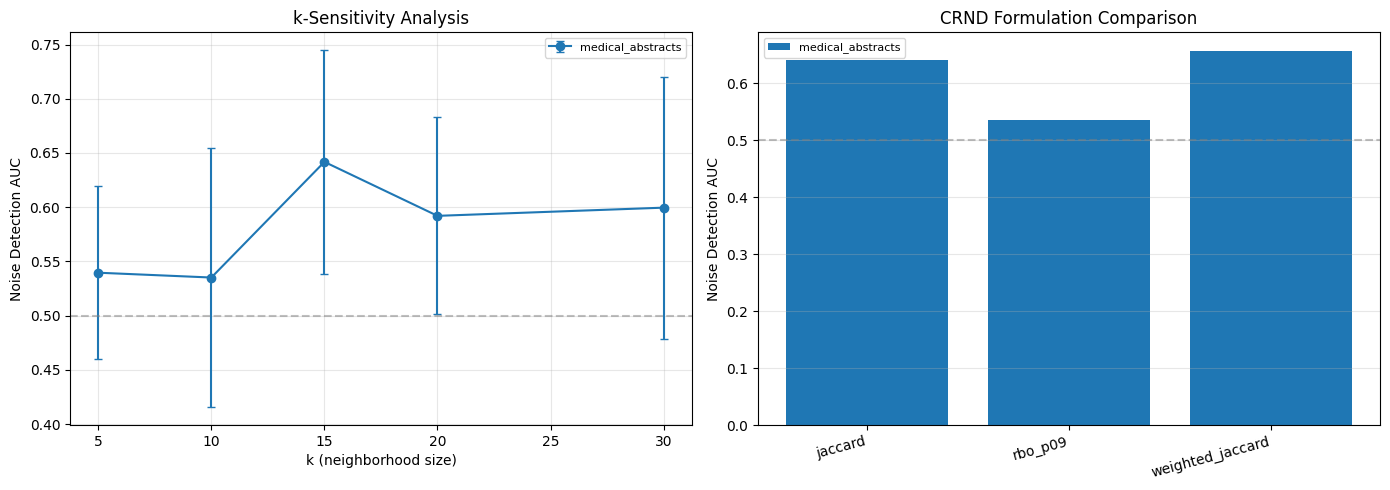


Total notebook runtime: 20.0s


In [15]:
from tabulate import tabulate

# ── 1. k-Sensitivity Table ──────────────────────────────
print("=" * 60)
print("k-Sensitivity Analysis (AUC)")
print("=" * 60)
for ds_name, k_sens in metadata_k_sensitivity.items():
    rows = []
    for k_str, vals in sorted(k_sens.items(), key=lambda x: int(x[0])):
        rows.append([int(k_str), f"{vals['mean_auc']:.4f}", f"{vals['std_auc']:.4f}", f"{vals['mean_crnd']:.4f}"])
    print(f"\n{ds_name}:")
    print(tabulate(rows, headers=["k", "AUC", "±std", "CRND"], tablefmt="simple"))

# ── 2. Distance Metric Comparison ──────────────────────
print("\n" + "=" * 60)
print("Distance Metric Ablation")
print("=" * 60)
for ds_name, dist_res in metadata_distance_metric.items():
    rows = []
    for metric, vals in dist_res.items():
        rows.append([metric, f"{vals['mean_auc']:.4f}", f"{vals['std_auc']:.4f}"])
    print(f"\n{ds_name}:")
    print(tabulate(rows, headers=["Metric", "AUC", "±std"], tablefmt="simple"))

# ── 3. Formulation Comparison ──────────────────────────
print("\n" + "=" * 60)
print("CRND Formulation Comparison")
print("=" * 60)
for ds_name, form_res in metadata_formulation.items():
    rows = []
    for fname, vals in form_res.items():
        rows.append([fname, f"{vals['mean_auc']:.4f}", f"{vals['std_auc']:.4f}", f"{vals['mean_crnd']:.4f}"])
    print(f"\n{ds_name}:")
    print(tabulate(rows, headers=["Form.", "AUC", "±std", "CRND"], tablefmt="simple"))

# ── 4. Pairwise Decomposition ─────────────────────────
print("\n" + "=" * 60)
print("Pairwise CRND Decomposition")
print("=" * 60)
for ds_name, pair_res in metadata_pairwise.items():
    rows = []
    for pair_name, vals in pair_res.items():
        rows.append([pair_name[:35], f"{vals['mean_auc']:.4f}"])
    print(f"\n{ds_name}:")
    print(tabulate(rows, headers=["Pair", "AUC"], tablefmt="simple"))

# ── 5. Confound Analysis ──────────────────────────────
print("\n" + "=" * 60)
print("Confound Partial Correlations")
print("=" * 60)
for ds_name, conf_res in metadata_confound.items():
    rows = []
    for cname, vals in conf_res.items():
        rho = vals.get("rho")
        p = vals.get("p_value")
        rho_str = f"{rho:.4f}" if rho is not None else "N/A"
        p_str = f"{p:.4f}" if p is not None else "N/A"
        rows.append([cname, rho_str, p_str])
    print(f"\n{ds_name}:")
    print(tabulate(rows, headers=["Control", "rho", "p-val"], tablefmt="simple"))

# ── 6. Baseline Comparison ────────────────────────────
print("\n" + "=" * 60)
print("Baseline vs CRND")
print("=" * 60)
for ds_name in datasets:
    rows = []
    if ds_name in metadata_baseline:
        for bname, bvals in metadata_baseline[ds_name].items():
            rows.append([bname[:30], f"{bvals['mean_auc']:.4f}"])
    if ds_name in metadata_formulation:
        for fname, fvals in metadata_formulation[ds_name].items():
            rows.append([f"CRND_{fname}", f"{fvals['mean_auc']:.4f}"])
    print(f"\n{ds_name}:")
    print(tabulate(rows, headers=["Method", "AUC"], tablefmt="simple"))

# ── Plots ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: k-sensitivity
ax = axes[0]
for ds_name, k_sens in metadata_k_sensitivity.items():
    ks = sorted([int(k) for k in k_sens.keys()])
    aucs = [k_sens[str(k)]["mean_auc"] for k in ks]
    stds = [k_sens[str(k)]["std_auc"] for k in ks]
    ax.errorbar(ks, aucs, yerr=stds, marker='o', label=ds_name, capsize=3)
ax.set_xlabel("k (neighborhood size)")
ax.set_ylabel("Noise Detection AUC")
ax.set_title("k-Sensitivity Analysis")
ax.legend(fontsize=8)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
ax.grid(True, alpha=0.3)

# Plot 2: Formulation comparison (grouped bar)
ax = axes[1]
formulations = list(next(iter(metadata_formulation.values())).keys())
x = np.arange(len(formulations))
width = 0.8 / len(metadata_formulation)
for i, (ds_name, form_res) in enumerate(metadata_formulation.items()):
    aucs = [form_res[f]["mean_auc"] for f in formulations]
    ax.bar(x + i * width, aucs, width, label=ds_name)
ax.set_xticks(x + width * (len(metadata_formulation) - 1) / 2)
ax.set_xticklabels(formulations, rotation=15, ha='right')
ax.set_ylabel("Noise Detection AUC")
ax.set_title("CRND Formulation Comparison")
ax.legend(fontsize=8)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nTotal notebook runtime: {time.time() - GLOBAL_START:.1f}s")